#Data Cleaning

In [3]:
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('game.csv')

df['game_date'] = pd.to_datetime(df['game_date'])
cutoff_date = '1985-04-16'
df = df[df['game_date'] >= cutoff_date]

df.set_index('game_id', inplace=True)

df.sort_values(by='game_date', ascending=True, inplace=True)

df.drop(columns=['matchup_home', 'video_available_home', 'matchup_away', 'video_available_away'], inplace=True)
df.dropna(inplace=True)

df["winner"] = df.apply(lambda row: "Home" if row["wl_home"] == "W" else "Away", axis=1)
df.drop(columns=['wl_home', 'wl_away'], inplace=True)

df.shape

(46105, 49)

#Home vs. Away: Free Throw Attempts

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ztest as ztest

Mean Free Throws Given to Away Team: 24.70445721722156
Standard Deviation Away: 7.908134118928598
Mean Free Throws Given to Home Team: 25.90940245092723
Standard DeviationHome: 8.362306790972092
zscore: -22.479562987132304
Reject the null hypothesis. pscore =  6.578371522053278e-112
Cohen's d: -0.1480569670993838


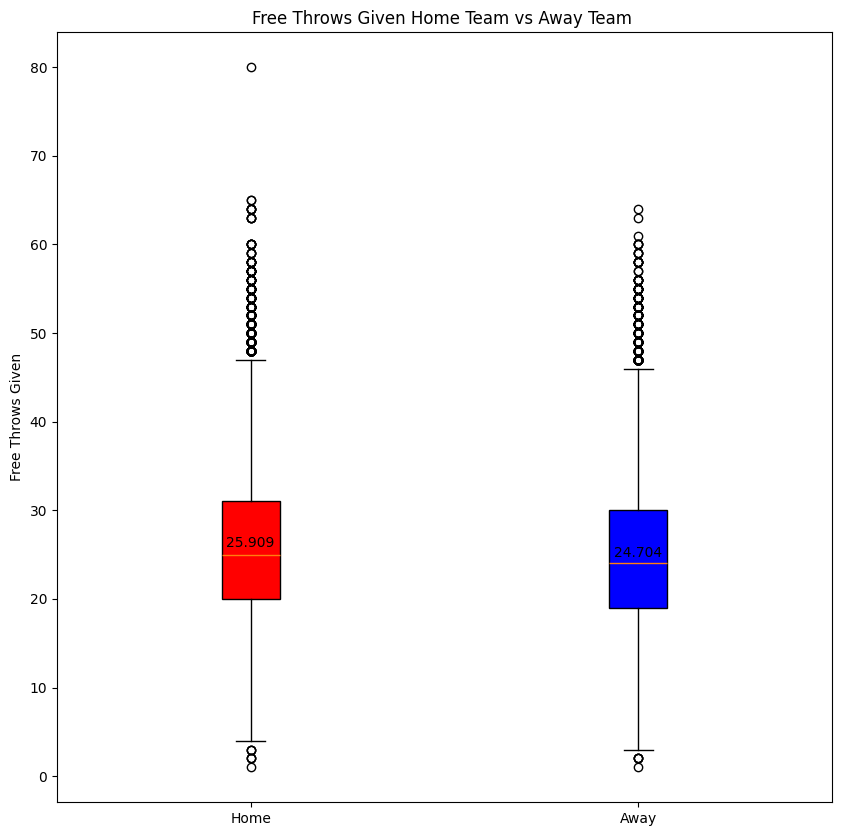

In [6]:
mean_fta_away = df['fta_away'].mean()
standard_deviation_fta_away = df['fta_away'].std()
mean_fta_home = df['fta_home'].mean()
standard_deviation_fta_home = df['fta_home'].std()
print(f"Mean Free Throws Given to Away Team: {mean_fta_away}")
print(f"Standard Deviation Away: {standard_deviation_fta_away}")
print(f"Mean Free Throws Given to Home Team: {mean_fta_home}")
print(f"Standard DeviationHome: {standard_deviation_fta_home}")

zscore, pscore = ztest(df['fta_away'], df['fta_home'], alternative='two-sided')
print(f"zscore: {zscore}")

alpha = 0.05
if pscore < alpha:
    print("Reject the null hypothesis. pscore = ", pscore)
else:
    print("Fail to reject the null hypothesis. pscore = ", pscore)

cohens_std = np.sqrt((standard_deviation_fta_away**2 + standard_deviation_fta_home**2) / 2)
cohen_d = (mean_fta_away - mean_fta_home) / cohens_std
print(f"Cohen's d: {cohen_d}")

plt.figure(figsize=(10, 10))
boxplot = plt.boxplot([df['fta_home'], df['fta_away']], labels=['Home', 'Away'], patch_artist=True)
plt.title('Free Throws Given Home Team vs Away Team ')
plt.ylabel('Free Throws Given')
boxplot['boxes'][0].set_facecolor('red')
boxplot['boxes'][1].set_facecolor('blue')
plt.text(1, mean_fta_home, f'{mean_fta_home:.3f}', horizontalalignment='center' )
plt.text(2, mean_fta_away, f'{mean_fta_away:.3f}', horizontalalignment='center')
plt.show()

A main feature of the dataset includes the amount of free throws given to the Home and Away team during their game. Thus, we decided to explore those features to determine whether or not being the home team effects the amount of free throws a team will receive. <br><br>
Using a two-sample z-test with a signficance level of 0.05 the following hypotheses were tested<br><br>
Hypotheses:
- HO = The Home team is given the same amount of free throws as the Away team
- HA = The Home team is given a different amount of free throws then the Away team <br><br>
The resulting test gave a zscore of -22.479562987132304 and a pscore of 6.578371522053278e-112. Due to the pscore being lower than the alpha value of 0.05 we reject the null hypothesis. There is a statistically signficant difference between the amount of free throws given for the home and away team. This means that the data consistently shows a difference between the free throws Home and Away teams are given. <br><br>



Due to the large nature of the data, values can be shown as statistically significant while in practicality are not significant. Hence, we calculated Cohen's D to determine practical difference between the mean. <br>
- Cohens D = -0.1480569670993838
  - This shows that there is a small difference in means where away teams are given less free throws. However, there is no practical difference between the means for the Home and Away teams. This is supported by the boxplot, which illustrates a similar distirbution between Home and Away teams, with slight favor towards the Home team.<br><br>



Summary: There is a significant difference between the free throws given to the Home and Away team. Consistently, there is a slight trend of Away teams being given less free throws. However, in practicality for the game of basketball there is a very miniscule difference.

#Home vs. Away: Margin of Victory


**Is there a significant difference between the margin of victory of home and away wins?**

$H_{0}$: Being home or away has no affect on margin of victory.

$H_{A}$: Being home leads to larger victories than being away.

$\alpha = 0.05$

Since we are only looking at wins, the data will likely be right skewed. This is because most wins are only by a few points (near 0) and margin of victory can only be positive. This means the data are not normal, so we will be using a Mann-Whitney U Test.

Mean home margin of victory: 11.977
Mean away margin of victory: 9.848

Mann-Whitney U Statistic: 2.927e+08
p-value: 2.347e-166



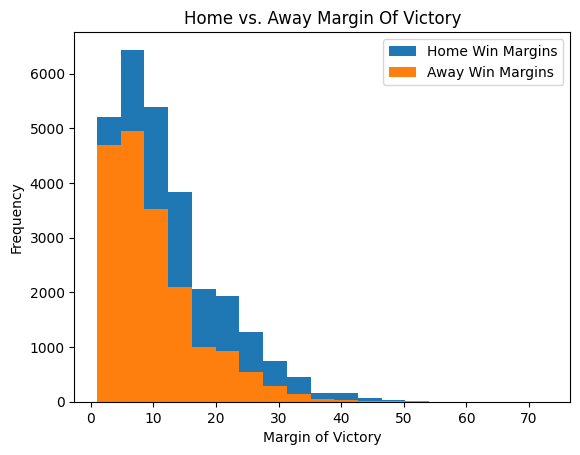

In [7]:
home_win_margins = df['plus_minus_home'][df['plus_minus_home'] > 0]
away_win_margins = df['plus_minus_away'][df['plus_minus_away'] > 0]
mean_home_win_margin = home_win_margins.mean()
mean_away_win_margin = away_win_margins.mean()
print(f'Mean home margin of victory: {mean_home_win_margin:.3f}')
print(f'Mean away margin of victory: {mean_away_win_margin:.3f}\n')

statistic, p_value = stats.mannwhitneyu(home_win_margins, away_win_margins, alternative='greater')
print(f'Mann-Whitney U Statistic: {statistic:.3e}')
print(f'p-value: {p_value:.3e}\n')

bin_edges = np.linspace(min(home_win_margins.min(), away_win_margins.min()), max(home_win_margins.max(), away_win_margins.max()), 20)

plt.hist(home_win_margins, bins=bin_edges, label='Home Win Margins')
plt.hist(away_win_margins, bins=bin_edges, label='Away Win Margins')
plt.legend()
plt.title('Home vs. Away Margin Of Victory')
plt.xlabel('Margin of Victory')
plt.ylabel('Frequency')
plt.show()

Since the p-value of $2.34 \times 10^{-166}$ is less than the $\alpha$ of 0.05, we reject the null hypothesis. There is significant evidence to show that being at home increases the margin of victory.


# Offensive vs defensive rebounds impact on score difference

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [9]:
df['oreb_diff'] = df.apply(lambda row: row['oreb_home'] - row['oreb_away'], axis=1)
df['dreb_diff'] = df.apply(lambda row: row['dreb_home'] - row['dreb_away'], axis=1)
df['reb_diff'] = df.apply(lambda row: row['oreb_diff'] + row['dreb_diff'], axis=1)

rebDf = df[['oreb_home', 'dreb_home', 'oreb_away', 'dreb_away', 'oreb_diff', 'dreb_diff', 'reb_diff', 'plus_minus_home']]
print("defensive rebound point difference correlation:",scipy.stats.pearsonr(rebDf['dreb_diff'], rebDf['plus_minus_home']))
print("offensive rebound point difference correlation:",scipy.stats.pearsonr(rebDf['oreb_diff'], rebDf['plus_minus_home']))

defensive rebound point difference correlation: PearsonRResult(statistic=np.float64(0.613248663932224), pvalue=np.float64(0.0))
offensive rebound point difference correlation: PearsonRResult(statistic=np.float64(-0.05373368270609853), pvalue=np.float64(7.754852615441134e-31))


Text(0, 0.5, 'offensive rebounds')

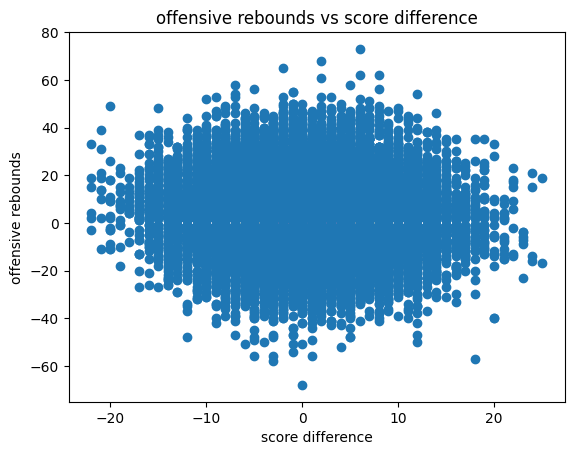

In [10]:
plt.scatter(rebDf['oreb_diff'], rebDf['plus_minus_home'])
plt.title("offensive rebounds vs score difference")
plt.xlabel("score difference")
plt.ylabel("offensive rebounds")

Text(0, 0.5, 'defensive rebounds')

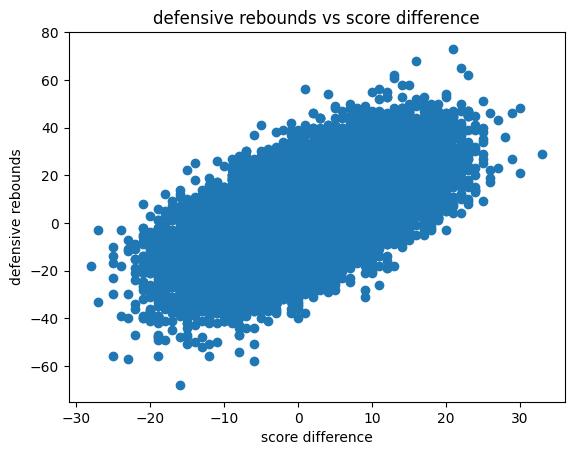

In [11]:
plt.scatter(rebDf['dreb_diff'], rebDf['plus_minus_home'])
plt.title("defensive rebounds vs score difference")
plt.xlabel("score difference")
plt.ylabel("defensive rebounds")

Rebounds are an important part of basketball. I wanted to see the correlation between offensive and defensive rebounds against the point difference.

My testing found that offensive rebounds with a pearson correlation coefficient of -0.0537 had almost no impact on the score difference.
On the other hand defensive rebounds had a pearson correlation coefficient of 0.6132 showing they moderately affected the score difference.

# Machine Learning

In [12]:
# Necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score

import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import ast
pd.set_option('display.max_columns', None)
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
import warnings # To suppress some warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Add the classifiers to the imports here:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor


from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor

In [13]:
X1 = df[['oreb_home', 'oreb_away', 'dreb_home', 'dreb_away', 'blk_home', 'blk_away', 'ft_pct_home', 'ft_pct_away', 'tov_home', 'tov_away', 'stl_home', 'stl_away']]
X = pd.DataFrame()
X['oreb_diff'] = df['oreb_home'] - df['oreb_away']
X['dreb_diff'] = df['dreb_home'] - df['dreb_away']
X['blk_diff'] = df['blk_home'] - df['blk_away']
X['ft_pct_diff'] = df['ft_pct_home'] - df['ft_pct_away']
X['stl_diff'] = df['stl_home'] - df['stl_away']
X['tov_diff'] = df['tov_home'] - df['tov_away']
X['pct_fg3_diff'] = (df['fg3a_home']/df['fga_home']) - (df['fg3a_away']/df['fga_away'])
X1['pct_fg3s_home'] = df['fg3a_home']/df['fga_home']
X1['pct_fg3s_away'] = df['fg3a_away']/df['fga_away']
y = df['plus_minus_home']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [14]:
kf = KFold(n_splits=5, shuffle=True)

lin_model = LinearRegression()
lin_model.fit(X_train,y_train)
print(f'R2 for Linear Regression: {lin_model.score(X_test,y_test):.3f}')

ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10], cv=kf).fit(X_train, y_train)
print(f'R2 for Ridge Regression: {ridge.score(X_test,y_test):.3f}')

rf_model = make_pipeline(StandardScaler(), RandomForestRegressor())
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')
print(f'R2 for Random Forest Regression: {rf_scores.mean():.3f}')

gb_model = make_pipeline(StandardScaler(), GradientBoostingRegressor())
gb_scores = cross_val_score(gb_model, X_train, y_train, cv=kf, scoring='r2')
print(f'R2 for Gradient Boosting Regression: {gb_scores.mean():.3f}')

R2 for Linear Regression: 0.733
R2 for Ridge Regression: 0.733
R2 for Random Forest Regression: 0.714
R2 for Gradient Boosting Regression: 0.732


In [15]:
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled).float()
y_train_tensor = torch.tensor(y_train.values).float().view(-1,1)
X_test_tensor = torch.tensor(X_test_scaled).float()
y_test_tensor = torch.tensor(y_test.values).float().view(-1,1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
class MLPModel(nn.Module):
  def __init__(self, feat_dim):
    super().__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(feat_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
    )

  def forward(self, x):
    return self.linear_relu_stack(x)

nn_model = MLPModel(feat_dim=X_train.shape[1])

In [28]:
### YOUR ANSWER HERE
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)


epochs = 100
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    nn_model.train()
    nn_model = nn_model.float()
    for batch_idx, (data, targets) in enumerate(train_loader):
        ### YOUR ANSWER HERE

        # Forward pass
        predicts = nn_model(data)
        loss = criterion(predicts, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()



    losses.append(running_loss/len(train_loader))
    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

print('Finished Training')

Epoch 1/100, Loss: 51.208215589432335
Epoch 2/100, Loss: 49.06371884374958
Epoch 3/100, Loss: 48.42718796510854
Epoch 4/100, Loss: 48.12833684936153
Epoch 5/100, Loss: 48.143025050035064
Epoch 6/100, Loss: 47.87951388197781
Epoch 7/100, Loss: 47.68895346251965
Epoch 8/100, Loss: 47.6913607184616
Epoch 9/100, Loss: 47.650529117038325
Epoch 10/100, Loss: 47.64959846489965
Epoch 11/100, Loss: 47.59783935216025
Epoch 12/100, Loss: 47.52733520415175
Epoch 13/100, Loss: 47.56140194121176
Epoch 14/100, Loss: 47.41706335989166
Epoch 15/100, Loss: 47.49194891434179
Epoch 16/100, Loss: 47.45691561802304
Epoch 17/100, Loss: 47.430447160732406
Epoch 18/100, Loss: 47.36022900914691
Epoch 19/100, Loss: 47.38357783976784
Epoch 20/100, Loss: 47.25423629906316
Epoch 21/100, Loss: 47.30754662139046
Epoch 22/100, Loss: 47.35241147361418
Epoch 23/100, Loss: 47.254689179393175
Epoch 24/100, Loss: 47.289983124083676
Epoch 25/100, Loss: 47.30455765471909
Epoch 26/100, Loss: 47.27046240172175
Epoch 27/100, Lo